<a href="https://colab.research.google.com/github/edwardliu24/edwardliu24.github.io/blob/master/hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fake News Classification

In this project, we will apply CNN for fake news classification.

## Peparation

First we need to import all the modules we need.

In [35]:
import pandas as pd
import tensorflow as tf
import nltk 
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import re
import string
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras import losses
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import plotly.express as px 
from plotly.io import write_html

## Data Preparation

Import data and clean it.

In [4]:
train_url = "https://github.com/PhilChodrow/PIC16b/blob/master/datasets/fake_news_train.csv?raw=true"
df = pd.read_csv(train_url)
le = LabelEncoder()
df["fake"] = le.fit_transform(df["fake"])
num_fake = len(df["fake"].unique())

## Make a Dataset 

Define a function to make the data as the dataset we desired. For example, remove the stop words.

In [5]:
nltk.download('stopwords')
stopword = stopwords.words('english')

def make_dataset(df):
  
  df['title'] = df['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopword)]))
  df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopword)]))

  ds = tf.data.Dataset.from_tensor_slices((
      {"title": df[["title"]],
       "text": df[["text"]]},
      {"fake": df["fake"]}
    ))
  return ds

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Apply the function to the data we need.

In [6]:
ds = make_dataset(df)

## Validation Data

Split 20% of the data for validation.

In [7]:
ds = ds.shuffle(buffer_size = len(ds))

train_size = int(0.8*len(ds))
val_size = int(0.2*len(ds))

train = ds.take(train_size).batch(20)
val = ds.skip(train_size).take(val_size).batch(20)


## Base rate

Compute the base rate.

In [11]:
print(len(ds),sum(df["fake"] == 1),sum(df["fake"] == 0))
11740/22449

22449 11740 10709


0.522963160942581

## TextVectorization

In [14]:
#preparing a text vectorization layer for tf model
size_vocabulary = 2000

def standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    no_punctuation = tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation),'')
    return no_punctuation 

title_vectorize_layer = TextVectorization(
    standardize=standardization,
    max_tokens=size_vocabulary, # only consider this many words
    output_mode='int',
    output_sequence_length=500) 

title_vectorize_layer.adapt(train.map(lambda x, y: x["title"]))

# Model 1

Model 1 would only use the article title as an input.

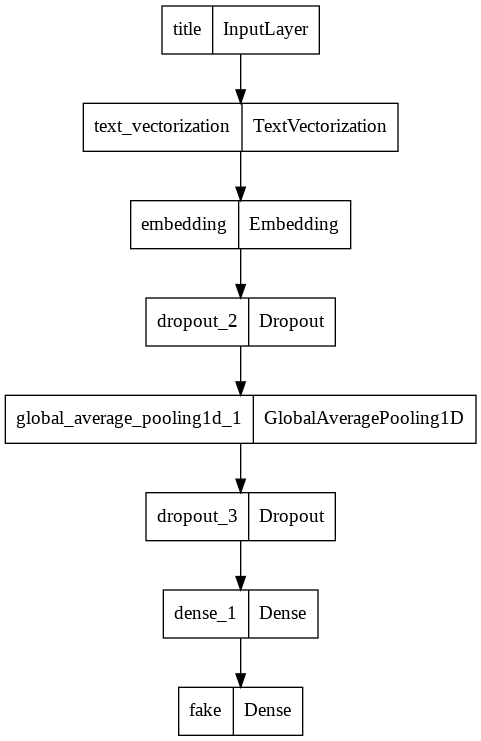

In [17]:
title_input = keras.Input(
    shape=(1,),
    name = "title",
    dtype = "string"
)

title_features = title_vectorize_layer(title_input)
title_features = layers.Embedding(size_vocabulary, output_dim = 2, name="embedding")(title_features)
title_features = layers.Dropout(0.2)(title_features)
title_features = layers.GlobalAveragePooling1D()(title_features)
title_features = layers.Dropout(0.2)(title_features)
title_features = layers.Dense(32, activation='relu')(title_features)

output = layers.Dense(num_fake, name="fake")(title_features) 

model1 = keras.Model(
    inputs = title_input,
    outputs = output
)

keras.utils.plot_model(model1)

In [19]:
model1.compile(optimizer="adam",
        loss = losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"])

history = model1.fit(train, 
            validation_data=val,
            epochs = 30,
            verbose = False)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['text'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


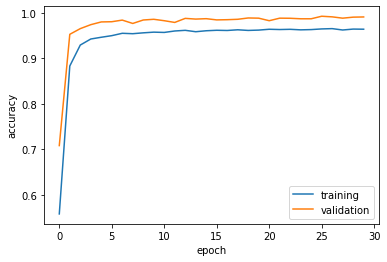

In [21]:
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()

The validation accuracy stabilizes around 95% to 98%.

# Model 2

Model 2 would only use article titles as input.

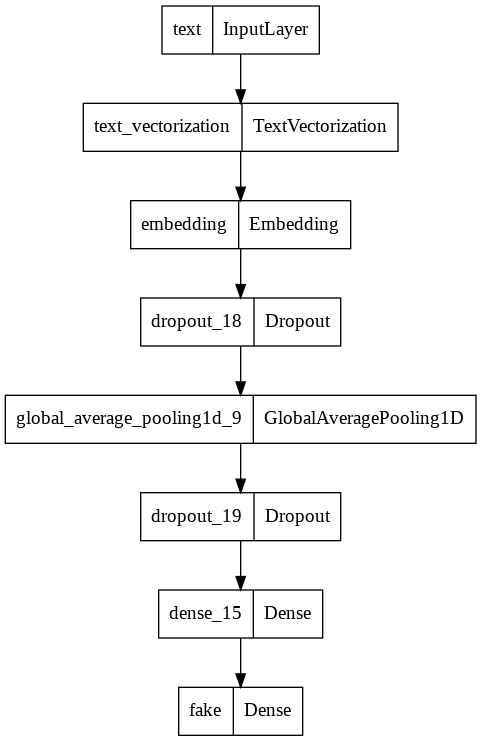

In [40]:
text_input = keras.Input(
    shape=(1,),
    name = "text", # same name as the dictionary key in the dataset
    dtype = "string"
)

text_features = title_vectorize_layer(text_input)
text_features = layers.Embedding(size_vocabulary, output_dim = 2, name="embedding")(text_features)
text_features = layers.Dropout(0.2)(text_features)
text_features = layers.GlobalAveragePooling1D()(text_features)
text_features = layers.Dropout(0.2)(text_features)
text_features = layers.Dense(32, activation='relu')(text_features)

output = layers.Dense(num_fake, name="fake")(text_features) 

model2 = keras.Model(
    inputs = text_input,
    outputs = output
)

keras.utils.plot_model(model2)

In [23]:
model2.compile(optimizer="adam",
        loss = losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"])

history = model2.fit(train, 
            validation_data=val,
            epochs = 30,
            verbose = False)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['title'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


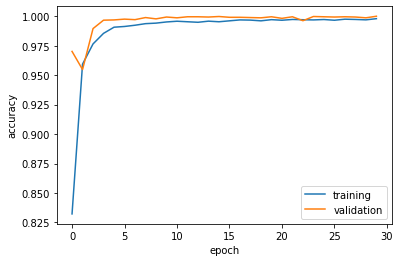

In [39]:
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()

The validation accuracy stablizes at around 95% to 98%.

# Model 3

Model 3 would use both articles texts and titles as input.

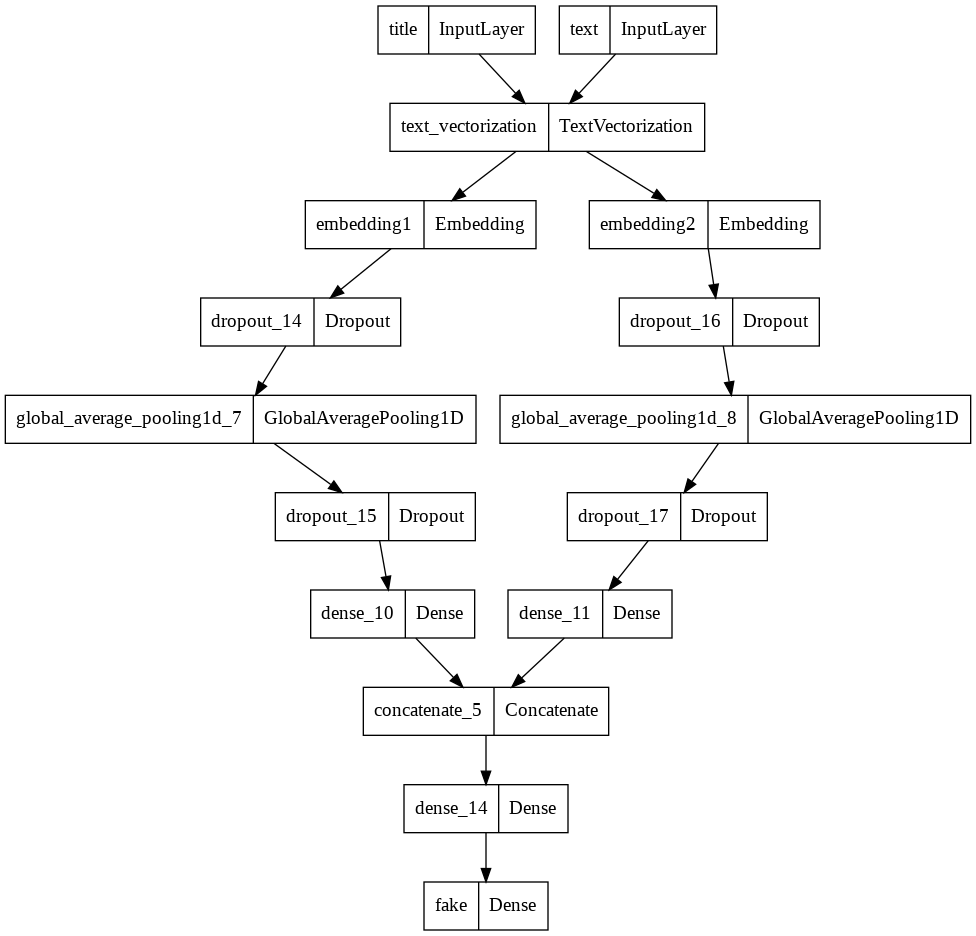

In [29]:
main = layers.concatenate([title_features, text_features], axis = 1) # Combine the layers of the first two models
main = layers.Dense(32, activation='relu')(main)

output = layers.Dense(num_fake, name="fake")(main) 
model3 = keras.Model(
    inputs = [title_input, text_input],
    outputs = output
)

keras.utils.plot_model(model3)

In [30]:
model3.compile(optimizer="adam",
              loss = losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])
history = model3.fit(train, 
                    validation_data=val,
                    epochs = 30,
                    verbose = False)

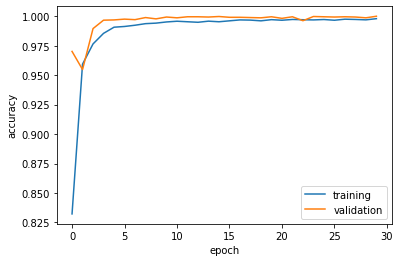

In [31]:
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()

The validation accuracy stabilizes at 99% which is impressive.

# Model Evaluation

Model 3 so far is the best model, we will use model 3 to evaluate the new data.

In [32]:
test_url = "https://github.com/PhilChodrow/PIC16b/blob/master/datasets/fake_news_test.csv?raw=true"
df_test = pd.read_csv(test_url)
ds = make_dataset(df_test)

In [33]:
ds = ds.shuffle(buffer_size = len(ds))
test = ds.batch(20)
model3.evaluate(test)

1123/1123 [==============================] - 6s 6ms/step - loss: 0.0224 - accuracy: 0.9939


[0.022355573251843452, 0.9939418435096741]

Model 3 scores a 99.4% of accuracy.

## Embedding Visualization

In [36]:
weights = model3.get_layer('embedding2').get_weights()[0] # get the weights from the embedding layer
vocab = title_vectorize_layer.get_vocabulary()                # get the vocabulary from our data prep for later

pca = PCA(n_components=2)
weights = pca.fit_transform(weights)

embedding_df = pd.DataFrame({
    'word' : vocab, 
    'x0'   : weights[:,0],
    'x1'   : weights[:,1]
})

In [41]:
fig = px.scatter(embedding_df, 
                 x = "x0", 
                 y = "x1", 
                 size = [2]*len(embedding_df),
                # size_max = 2,
                 hover_name = "word")
write_html(fig, "embedding.html")

Word 'trumps' and 'gop' are most likely to be used in fake news, and their positions are far from the origin. On the other hands, words 'election', 'aliens','syrian' are neutral which are not helpful for the model to distiguish fake news. 